In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold,KFold
from scipy.stats import norm,skew
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix

import category_encoders as ce

import lightgbm as lgbm
import xgboost as xgb

pd.options.display.max_columns=None

In [2]:
train=pd.read_csv("Training_dataset_Original.csv",low_memory=False)
leader=pd.read_csv("Leaderboard_dataset.csv",low_memory=False)
test=pd.read_csv("Evaluation_dataset.csv",low_memory=False)

target=train['default_ind']
train.drop(columns=['default_ind'],inplace=True)

print(train.shape,leader.shape,test.shape)
train.head()

(80000, 48) (25000, 48) (25000, 48)


,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar11,mvar12,mvar13,mvar14,mvar15,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar22,mvar23,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar30,mvar31,mvar32,mvar33,mvar34,mvar35,mvar36,mvar37,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,missing,6423,3067,123875,missing,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,na,0,C
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,missing,765,1931,42613,missing,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,missing,2251,169,0.4167,0,0,8,0,2,0,99.129,missing,0,13,0.63836,na,na,L
2,230034,1745,0.4001,0.000,0.0,0.0,missing,2536,missing,missing,2536,missing,missing,missing,76109,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,669,4623,3772,missing,missing,25.0833,0,na,1,na,1,0,missing,29.29,0,1,1.00000,na,0,C
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,missing,0,0,84235,missing,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,missing,3741,215,10.3333,0,0,3,3,2,0,96.272,missing,0.15385,3,0.53241,0,0,L
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,missing,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,missing,1947,158,0.9167,0,0,2,3,2,0,115.019,missing,0,1,0.92665,na,na,L


## TARGET VARIABLE

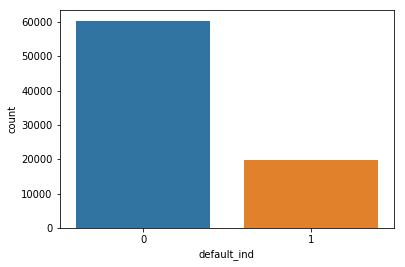

In [3]:
sns.countplot(target)
plt.show()

In [4]:
target.value_counts()

0    60303
1    19697
Name: default_ind, dtype: int64

The target is unbalanced(not very high ratio). The percentage of positive targets is 32%.

In [5]:
train.replace(to_replace=['missing','na'],value=np.nan,inplace=True)
test.replace(to_replace=['missing','na'],value=np.nan,inplace=True)
leader.replace(to_replace=['missing','na'],value=np.nan,inplace=True)

print(train.shape,leader.shape,test.shape)
train.head()

(80000, 48) (25000, 48) (25000, 48)


,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar11,mvar12,mvar13,mvar14,mvar15,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar22,mvar23,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar30,mvar31,mvar32,mvar33,mvar34,mvar35,mvar36,mvar37,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,NaN,6423,3067,123875,NaN,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,NaN,0,C
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,NaN,765,1931,42613,NaN,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,NaN,2251,169,0.4167,0,0,8,0,2,0,99.129,NaN,0,13,0.63836,NaN,NaN,L
2,230034,1745,0.4001,0.000,0.0,0.0,NaN,2536,NaN,NaN,2536,NaN,NaN,NaN,76109,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,669,4623,3772,NaN,NaN,25.0833,0,NaN,1,NaN,1,0,NaN,29.29,0,1,1.00000,NaN,0,C
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,NaN,0,0,84235,NaN,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,NaN,3741,215,10.3333,0,0,3,3,2,0,96.272,NaN,0.15385,3,0.53241,0,0,L
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,NaN,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,NaN,1947,158,0.9167,0,0,2,3,2,0,115.019,NaN,0,1,0.92665,NaN,NaN,L


In [6]:
trainkey=train['application_key']
testkey=test['application_key']
leaderkey=leader['application_key']

# train.drop(columns=['application_key'],inplace=True)
# test.drop(columns=['application_key'],inplace=True)
# leader.drop(columns=['application_key'],inplace=True)


print(train.shape,leader.shape,test.shape)
train.head()

(80000, 48) (25000, 48) (25000, 48)


,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar11,mvar12,mvar13,mvar14,mvar15,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar22,mvar23,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar30,mvar31,mvar32,mvar33,mvar34,mvar35,mvar36,mvar37,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,NaN,6423,3067,123875,NaN,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,NaN,0,C
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,NaN,765,1931,42613,NaN,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,NaN,2251,169,0.4167,0,0,8,0,2,0,99.129,NaN,0,13,0.63836,NaN,NaN,L
2,230034,1745,0.4001,0.000,0.0,0.0,NaN,2536,NaN,NaN,2536,NaN,NaN,NaN,76109,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,669,4623,3772,NaN,NaN,25.0833,0,NaN,1,NaN,1,0,NaN,29.29,0,1,1.00000,NaN,0,C
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,NaN,0,0,84235,NaN,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,NaN,3741,215,10.3333,0,0,3,3,2,0,96.272,NaN,0.15385,3,0.53241,0,0,L
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,NaN,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,NaN,1947,158,0.9167,0,0,2,3,2,0,115.019,NaN,0,1,0.92665,NaN,NaN,L


## MISSING VALUES

In [7]:
na=(train.isnull().sum()/train.shape[0]).reset_index().rename(columns=
                                                              {0:'percentage','index':'features'}).sort_values(
                                                                    by=['percentage'],ascending=False)

na=na.loc[na['percentage']!=0]

print(na.shape)
na.head(45)

(45, 2)


,features,percentage
40,mvar40,0.781963
31,mvar31,0.702725
41,mvar41,0.682225
45,mvar45,0.560688
11,mvar11,0.560238
23,mvar23,0.503100
30,mvar30,0.455213
35,mvar35,0.412675
15,mvar15,0.400838
22,mvar22,0.364050


## LABEL ENCODING

In [8]:
# replacing the variables
train['mvar47'].replace(to_replace=['C','L'],value=[0,1],inplace=True)
leader['mvar47'].replace(to_replace=['C','L'],value=[0,1],inplace=True)
test['mvar47'].replace(to_replace=['C','L'],value=[0,1],inplace=True)


train=train.astype('float')
leader=leader.astype('float')
test=test.astype('float')

print(train.shape,test.shape,leader.shape)
train.head()

(80000, 48) (25000, 48) (25000, 48)


,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar11,mvar12,mvar13,mvar14,mvar15,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar22,mvar23,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar30,mvar31,mvar32,mvar33,mvar34,mvar35,mvar36,mvar37,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,230032.0,1696.0,1.6541,0.000,0.0,0.0,0.0,6015.0,322.0,40369.0,18414.0,NaN,6423.0,3067.0,123875.0,NaN,1.0,1.0,1.0,3.0,3.0,94.78,8987.18,NaN,72.25,1462.0,4532.0,2890.0,61.0,4532.0,1095.0,3376.0,625.0,1.1667,1.0,0.0,8.0,10.0,4.0,1.0,73.780,82.547,0.08696,10.0,0.63899,NaN,0.0,0.0
1,230033.0,1846.0,0.8095,0.000,0.0,0.0,102.0,7532.0,3171.0,18234.0,13664.0,NaN,765.0,1931.0,42613.0,NaN,0.0,0.0,0.0,0.0,0.0,74.25,953.06,953.06,4.80,1028.0,2099.0,2099.0,30386.0,2281.0,NaN,2251.0,169.0,0.4167,0.0,0.0,8.0,0.0,2.0,0.0,99.129,NaN,0.00000,13.0,0.63836,NaN,NaN,1.0
2,230034.0,1745.0,0.4001,0.000,0.0,0.0,NaN,2536.0,NaN,NaN,2536.0,NaN,NaN,NaN,76109.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,669.0,4623.0,3772.0,NaN,NaN,25.0833,0.0,NaN,1.0,NaN,1.0,0.0,NaN,29.290,0.00000,1.0,1.00000,NaN,0.0,0.0
3,230035.0,1739.0,0.2193,0.000,0.0,0.0,1982.0,26440.0,4955.0,20316.0,37013.0,NaN,0.0,0.0,84235.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.00,NaN,0.00,1308.0,2525.0,791.0,91.0,5992.0,NaN,3741.0,215.0,10.3333,0.0,0.0,3.0,3.0,2.0,0.0,96.272,NaN,0.15385,3.0,0.53241,0.0,0.0,1.0
4,230036.0,1787.0,0.0118,0.225,0.0,0.0,5451.0,5494.0,5494.0,7987.0,4696.0,NaN,2257.0,27815.0,123875.0,524848.0,0.0,0.0,0.0,0.0,0.0,20.51,796.67,NaN,28.72,801.0,2281.0,2281.0,487.0,2707.0,NaN,1947.0,158.0,0.9167,0.0,0.0,2.0,3.0,2.0,0.0,115.019,NaN,0.00000,1.0,0.92665,NaN,NaN,1.0


## REPLACING THE MISSING VALUES

In [9]:
data=pd.concat([train,leader,test])


for i in data.columns:
    data[i].fillna(data[i].median(),inplace=True)

    
train=data.iloc[:train.shape[0],:]
leader=data.iloc[train.shape[0]:train.shape[0]+leader.shape[0],:]
test=data.iloc[train.shape[0]+leader.shape[0]:,:]

print(train.shape,test.shape,leader.shape)
train.head()

(80000, 48) (25000, 48) (25000, 48)


,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar11,mvar12,mvar13,mvar14,mvar15,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar22,mvar23,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar30,mvar31,mvar32,mvar33,mvar34,mvar35,mvar36,mvar37,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,230032.0,1696.0,1.6541,0.000,0.0,0.0,0.0,6015.0,322.0,40369.0,18414.0,1794.0,6423.0,3067.0,123875.0,216386.0,1.0,1.0,1.0,3.0,3.0,94.78,8987.180,3632.48,72.250,1462.0,4532.0,2890.0,61.0,4532.0,1095.0,3376.0,625.0,1.1667,1.0,0.0,8.0,10.0,4.0,1.0,73.780,82.547,0.08696,10.0,0.63899,0.0,0.0,0.0
1,230033.0,1846.0,0.8095,0.000,0.0,0.0,102.0,7532.0,3171.0,18234.0,13664.0,1794.0,765.0,1931.0,42613.0,216386.0,0.0,0.0,0.0,0.0,0.0,74.25,953.060,953.06,4.800,1028.0,2099.0,2099.0,30386.0,2281.0,2829.0,2251.0,169.0,0.4167,0.0,0.0,8.0,0.0,2.0,0.0,99.129,78.941,0.00000,13.0,0.63836,0.0,0.0,1.0
2,230034.0,1745.0,0.4001,0.000,0.0,0.0,297.0,2536.0,2504.0,14518.0,2536.0,1794.0,2962.0,4351.0,76109.0,216386.0,0.0,0.0,0.0,0.0,0.0,59.24,3887.535,3632.48,39.835,1497.0,2768.0,2585.0,669.0,4623.0,3772.0,3589.0,308.0,25.0833,0.0,0.0,1.0,3.0,1.0,0.0,100.000,29.290,0.00000,1.0,1.00000,0.0,0.0,0.0
3,230035.0,1739.0,0.2193,0.000,0.0,0.0,1982.0,26440.0,4955.0,20316.0,37013.0,1794.0,0.0,0.0,84235.0,216386.0,0.0,0.0,0.0,0.0,0.0,59.24,0.000,3632.48,0.000,1308.0,2525.0,791.0,91.0,5992.0,2829.0,3741.0,215.0,10.3333,0.0,0.0,3.0,3.0,2.0,0.0,96.272,78.941,0.15385,3.0,0.53241,0.0,0.0,1.0
4,230036.0,1787.0,0.0118,0.225,0.0,0.0,5451.0,5494.0,5494.0,7987.0,4696.0,1794.0,2257.0,27815.0,123875.0,524848.0,0.0,0.0,0.0,0.0,0.0,20.51,796.670,3632.48,28.720,801.0,2281.0,2281.0,487.0,2707.0,2829.0,1947.0,158.0,0.9167,0.0,0.0,2.0,3.0,2.0,0.0,115.019,78.941,0.00000,1.0,0.92665,0.0,0.0,1.0


## CONVERTING DATA TO NUMPY ARRAYS

In [10]:
X=train.iloc[:,1:].values
y=target.values
X_test=test.iloc[:,1:].values
X_leader=leader.iloc[:,1:].values

features=train.columns[1:]

print(X.shape,y.shape)
print(X_test.shape,X_leader.shape)

(80000, 47) (80000,)
(25000, 47) (25000, 47)


In [11]:
n_folds=5
kfold=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=42)

preds_train_lgbm=np.zeros((X.shape[0],))
preds_leader_lgbm=np.zeros((X_leader.shape[0],))
preds_test_lgbm=np.zeros((X_test.shape[0],))

feature_importance=pd.DataFrame()
scores=np.zeros((n_folds,))

for nfold,(train_index,val_index) in enumerate(kfold.split(X,y)):
    X_train,X_val=X[train_index],X[val_index]
    y_train,y_val=y[train_index],y[val_index]

    clf=LogisticRegression()
    

    clf.fit(X_train,y_train)
    
    # saving the oof predicitons
    preds_train_lgbm[val_index]=clf.predict_proba(X_val)[:,1]
    
    # adding the predictions in eval and leaderboard data set
    preds_leader_lgbm=preds_leader_lgbm+clf.predict_proba(X_leader)[:,1]/n_folds
    
    preds_test_lgbm=preds_test_lgbm+clf.predict_proba(X_test)[:,1]/n_folds
    
    # saving the score
    scores[nfold]=f1_score(y_val,preds_train_lgbm[val_index]>0.5)
        
    print("Training F1 Score for fold",nfold+1,"is")
    print(f1_score(y_train,(clf.predict_proba(X_train)[:,1]>0.5)))
    print("Validation F1 score for fold",nfold+1,"is")
    print(scores[nfold])

print("Full f1  score is",f1_score(y,preds_train_lgbm>0.5))
print("The mean of f1 scores is",np.mean(scores))
print("The standard deviation of f1 scores is",np.std(scores))

Training F1 Score for fold 1 is
0.250515204825333
Validation F1 score for fold 1 is
0.24994984954864594
Training F1 Score for fold 2 is
0.30829665388802124
Validation F1 score for fold 2 is
0.3054131054131054
Training F1 Score for fold 3 is
0.3237198900433304
Validation F1 score for fold 3 is
0.32611131864026893
Training F1 Score for fold 4 is
0.29133137377728524
Validation F1 score for fold 4 is
0.2835130970724191
Training F1 Score for fold 5 is
0.24483210648381568
Validation F1 score for fold 5 is
0.25504697181690983
Full f1  score is 0.28481724097833244
The mean of f1 scores is 0.28400686849826984
The standard deviation of f1 scores is 0.029085431632916266


## SAVING THE OOF'S

In [12]:
oof=pd.DataFrame()
oof['application_key']=trainkey
oof['predictions']=preds_train_lgbm
oof['default_ind']=target

print("OOF shape is",oof.shape)
oof.to_csv("stacking/oof_lr.csv",index=False)

leader_preds=pd.DataFrame()
leader_preds['application_key']=leaderkey
leader_preds['predicitions']=preds_leader_lgbm

print("Leader preds shape is",leader_preds.shape)
leader_preds.to_csv("stacking/leader_preds_lr.csv",index=False)

test_preds=pd.DataFrame()
test_preds['application_key']=testkey
test_preds['predictions']=preds_test_lgbm

print("Test preds shape is",test_preds.shape)
test_preds.to_csv("stacking/test_preds_lr.csv",index=False)

OOF shape is (80000, 3)
Leader preds shape is (25000, 2)
Test preds shape is (25000, 2)


## SUBMISSION

In [ ]:
sub_count=11

sub=pd.DataFrame()
sub['application_key']=leaderkey
sub['default_ind']=preds_leader_lgbm
sub['default_ind']=(sub['default_ind']>0.5).astype(int)
print(sub.shape)
sub.head()

In [ ]:
sub.to_csv("submissions/Birdie_IITPalakkad_"+str(sub_count)+".csv",index=False,header=None)